Problem statement

The objective of this dataset is to build a predictive model for diagnosing diabetes in female patients who are at least 21 years old and of Pima Indian heritage. The model should predict whether a patient has diabetes (Outcome = 1) or does not have diabetes (Outcome = 0) based on several diagnostic measurements, including glucose level, blood pressure, skin thickness, insulin level, BMI, diabetes pedigree function, and age.

### About Data
- `Pregnancies`: Number of pregnancies
- `Glucose`: Glucose level in blood
- `BloodPressure`: Blood pressure measurement
- `SkinThickness`: Thickness of the skin
- `Insulin`: Insulin level in blood
- `BMI`: Body mass index
- `DiabetesPedigreeFunction`: Diabetes percentage
- `Age`: Age
- `Outcome`: Final result (1: Yes, the individual has diabetes; 0: No, the individual does not have diabetes)

### 1) Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv(r'C:\Users\parha\Documents\Data_Analysis_projects\diabets\diabetes (1).csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 3) Data Checks to Perform

In [4]:
def check_detail(dataframe):
    d = {'SHAPE': dataframe.shape,
        'COLUMNS': dataframe.columns,
        'INDEX': dataframe.index,
        'VALUE TYPES': dataframe.dtypes,
        'DUPLICATED VALUES': dataframe.duplicated().sum(),
        'NUMBER OF UNIQUE VALUES': dataframe.nunique(),
        'ANY MISSING VALUES': dataframe.isnull().values.any(),
        'MISSING VALUES': dataframe.isnull().sum(),
        'DESCRIBE.T': dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T}
    hashtags = '---------------------------'
    for key, val in d.items():
        print(f'{hashtags} {key} {hashtags}')
        print(val)
    print(f'{hashtags} {"LIST END"} {hashtags}')
   

check_detail(dataframe=df)

--------------------------- SHAPE ---------------------------
(768, 9)
--------------------------- COLUMNS ---------------------------
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
--------------------------- INDEX ---------------------------
RangeIndex(start=0, stop=768, step=1)
--------------------------- VALUE TYPES ---------------------------
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
--------------------------- DUPLICATED VALUES ---------------------------
0
--------------------------- NUMBER OF UNIQUE VALUES ---------------------------
Pregnancies                  17
Glucose   

In [7]:
def grab_col_names(df):
    # Separate columns into categorical and numerical
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    print(f'cat_col: {len(categorical_cols)}')
    print(f'num_col: {len(numerical_cols)}')

    return categorical_cols, numerical_cols

In [8]:
def identify_check(dataframe):
    print('-' * 80)
    print(f'Categorical : {categorical_cols}')
    print('-' * 80)
    print(f'Numerical : {numerical_cols}')


categorical_cols, numerical_cols = grab_col_names(df)
identify_check(df)

cat_col: 0
num_col: 9
--------------------------------------------------------------------------------
Categorical : Index([], dtype='object')
--------------------------------------------------------------------------------
Numerical : Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [9]:
### 4) Exploratory data analysis

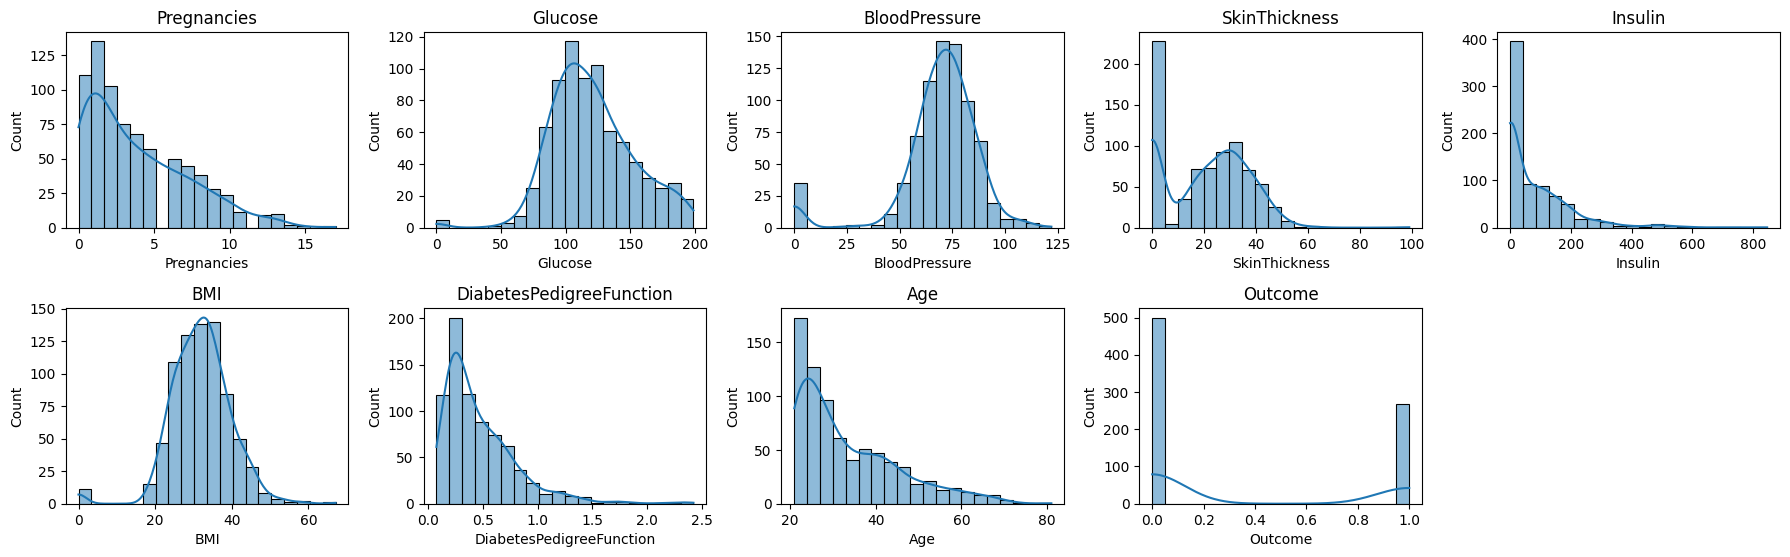

In [12]:
# Distribution of Numerical Features
numerical_features = list(numerical_cols)

plt.figure(figsize=(18,8))
for feature in numerical_features:
    plt.subplot(3,5,numerical_features.index(feature)+ 1)
    sns.histplot(data=df[feature],bins=20,kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

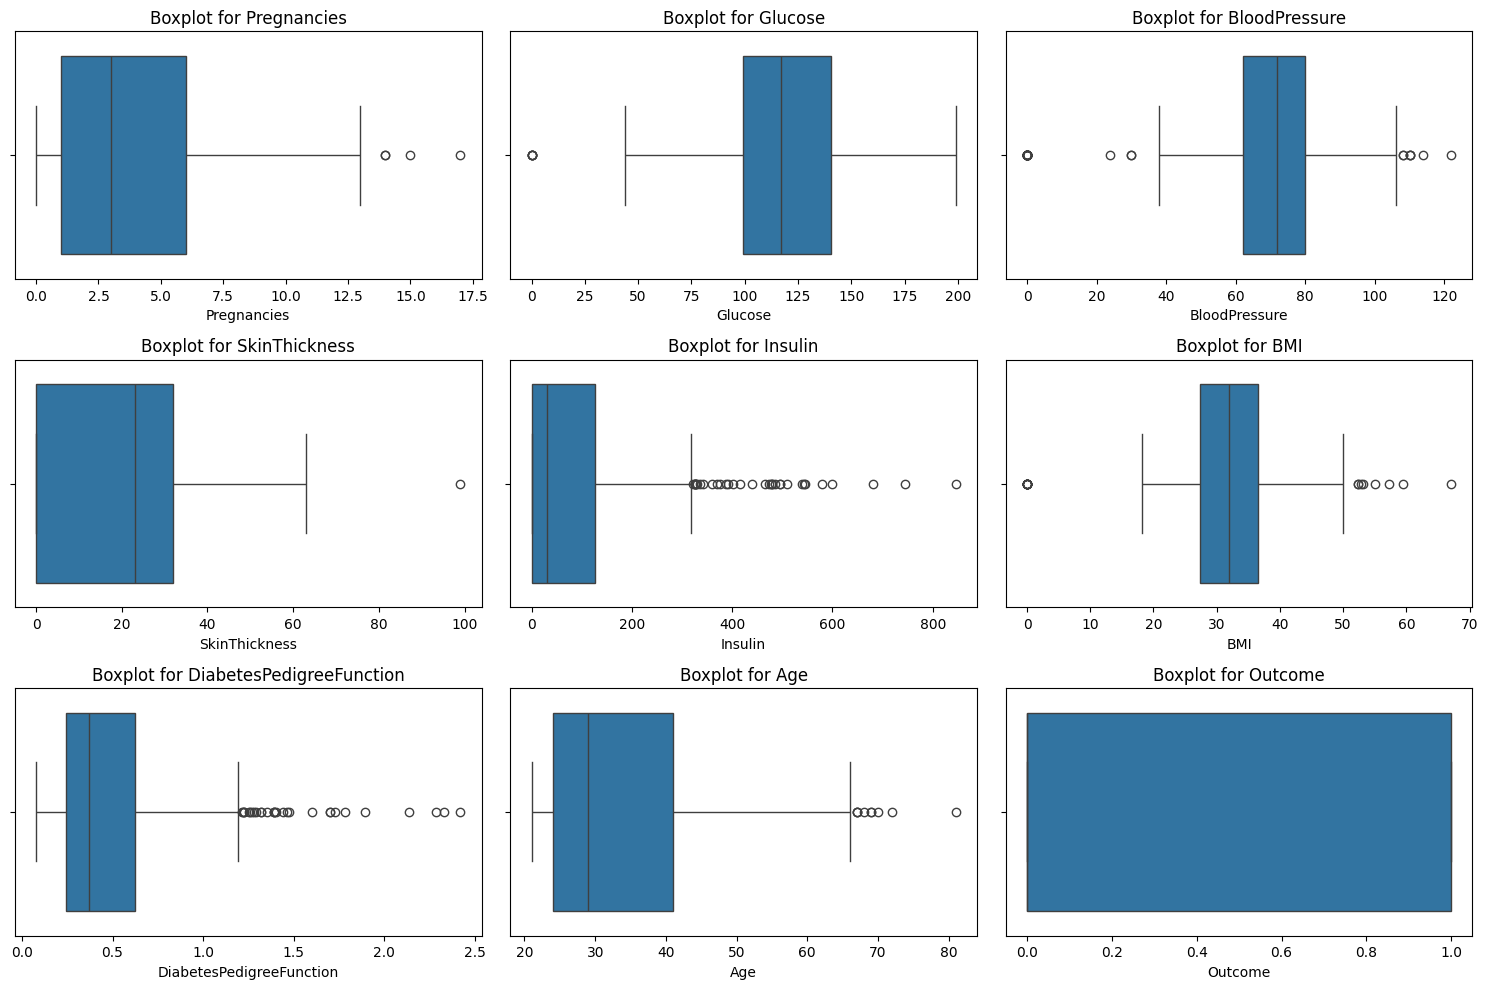

In [13]:
num_rows, num_cols = 3, 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Loop through numeric columns and create boxplots
for i, column in enumerate(df.columns):
    sns.boxplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

# Remove any remaining empty subplots
for j in range(len(df.columns), len(axes)): 
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

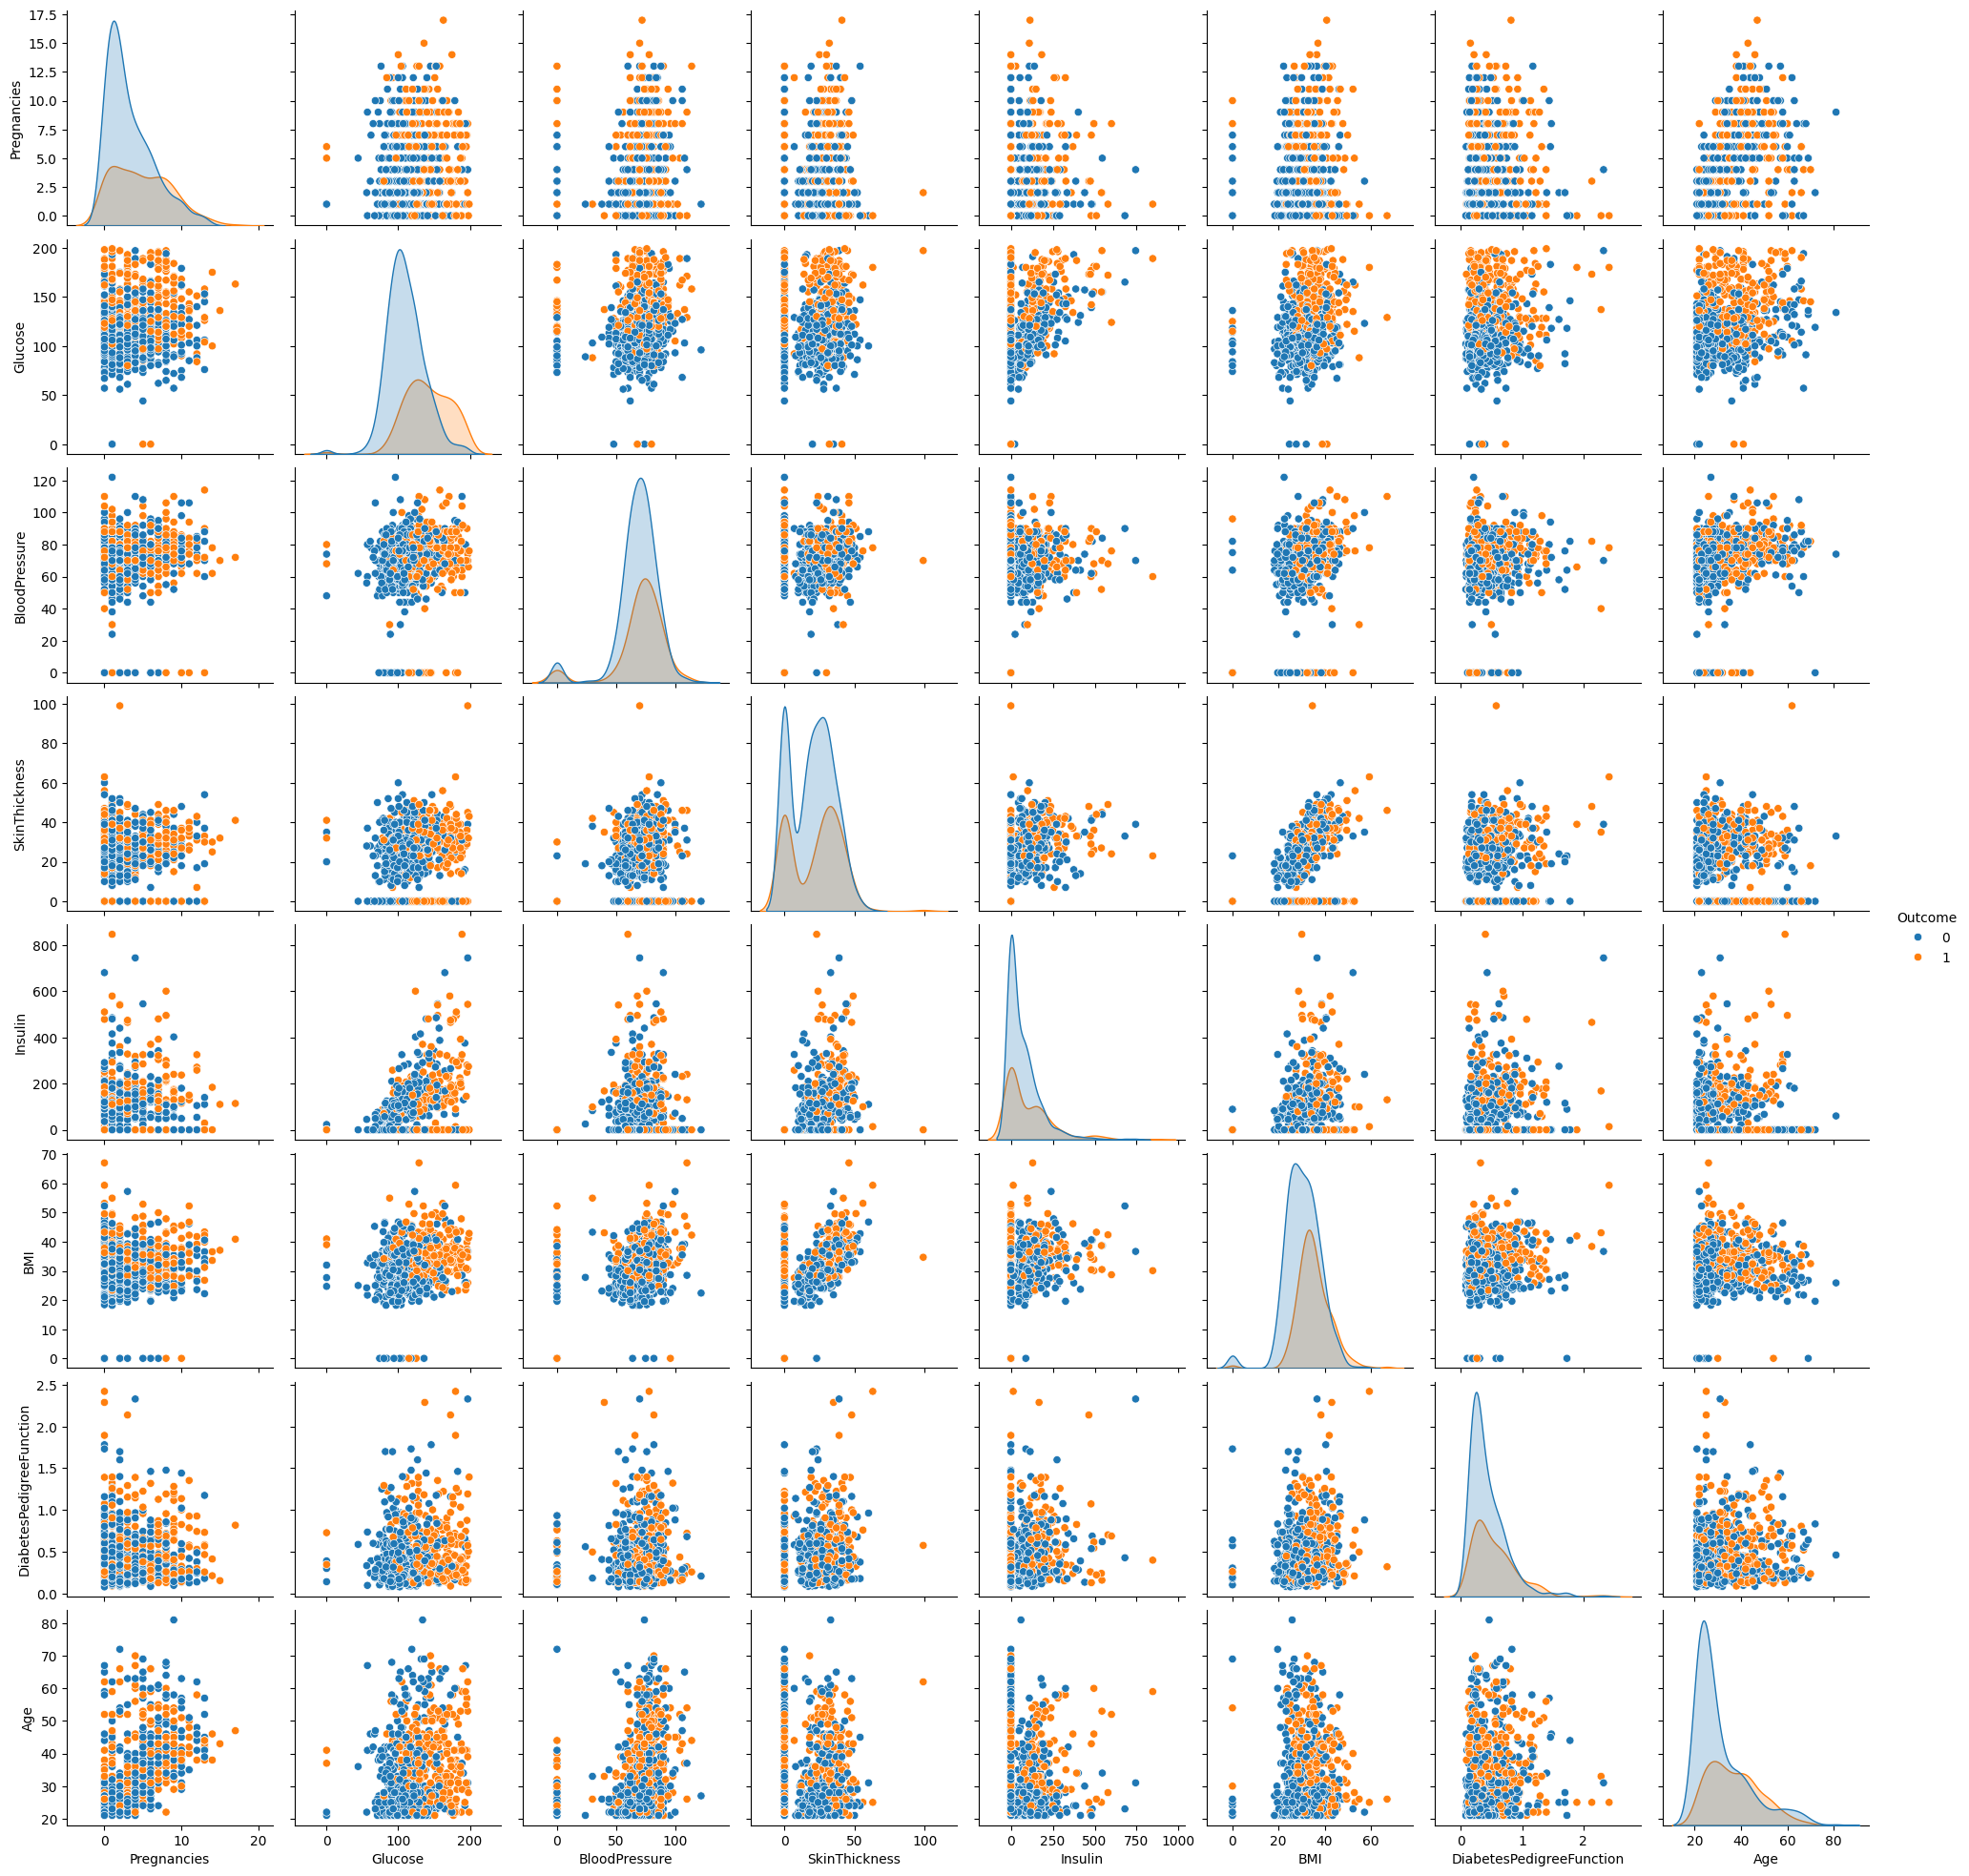

In [14]:
sns.pairplot(data = df, hue = 'Outcome' )
plt.show()

Text(0.5, 1.0, 'Age and Outcome Correlation')

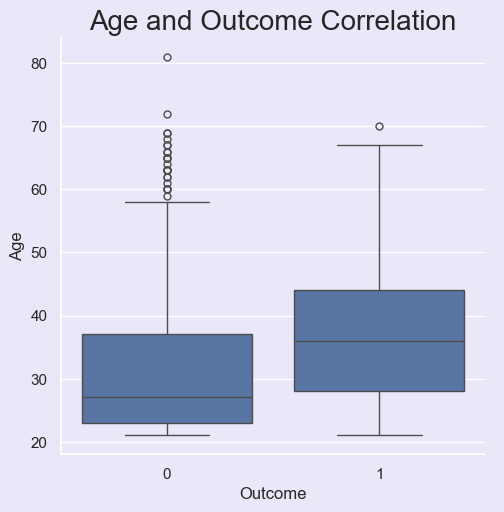

In [26]:
p=sns.catplot(x="Outcome",y="Age", data=df, kind='box')
plt.title("Age and Outcome Correlation", size=20, y=1.0)

Text(0.5, 1.0, 'Glucose and Outcome Correlation')

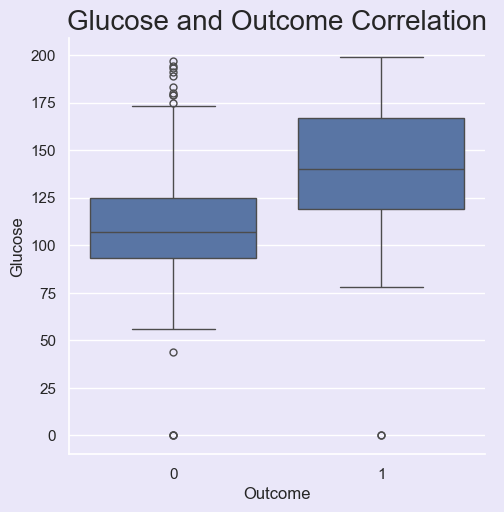

In [25]:
p=sns.catplot(x="Outcome",y="Glucose", data=df, kind='box')
plt.title("Glucose and Outcome Correlation", size=20, y=1.0)


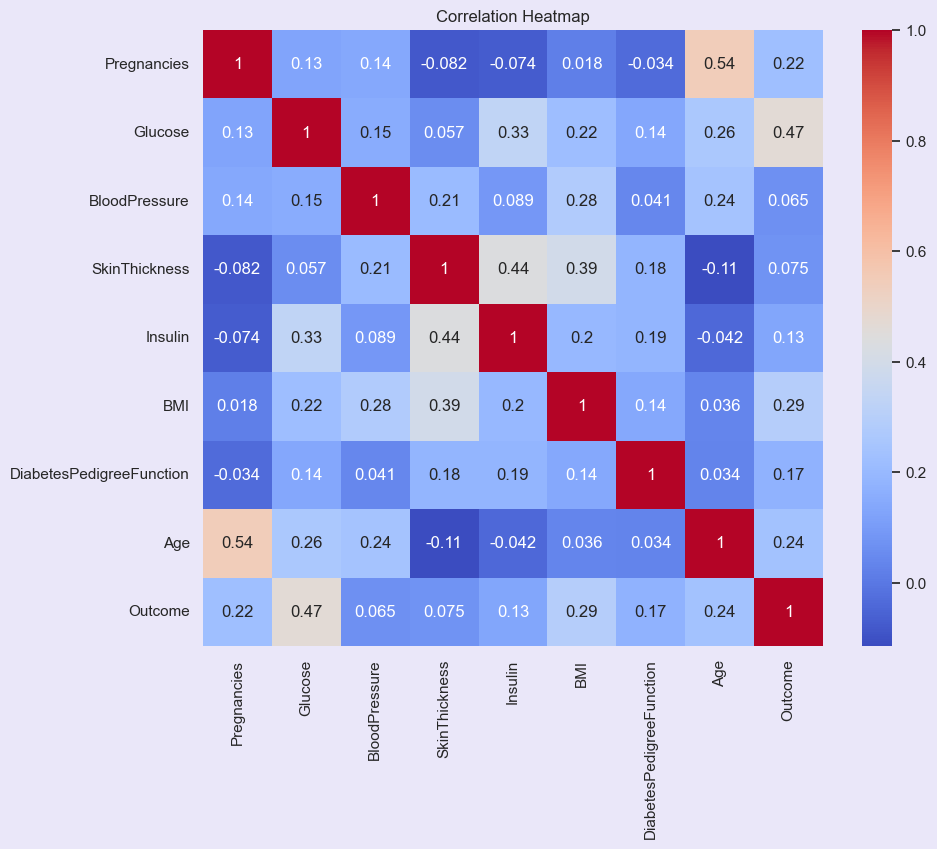

In [27]:
# Correlation Analysis
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 5) Data Pre-Processing

##### Handling Outliers

In [28]:
for column_name in numerical_cols:
    Q1 = np.percentile(df[column_name], 25, interpolation='midpoint')
    Q3 = np.percentile(df[column_name], 75, interpolation='midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR

    # Find outliers in the specified column
    outliers = df[(df[column_name] < low_lim) | (df[column_name] > up_lim)][column_name]

    # Replace outliers with the respective lower or upper limit
    df[column_name] = np.where(df[column_name] < low_lim, low_lim, df[column_name])
    df[column_name] = np.where(df[column_name] > up_lim, up_lim, df[column_name])

#### Get `input` and `target` columns

In [33]:
X = df.drop('Outcome', axis = 1)
y = df['Outcome']

In [35]:
# Splitting data for the training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

def calculate_metrics(y_train,y_test,y_pred_train,y_pred_test):
    acc_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)

    p = precision_score(y_test, y_pred_test,average='weighted')
    r = recall_score(y_test, y_pred_test,average='weighted')

    print(f'acc train: {acc_train} \nacc test: {acc_test} \nprecision: {p} \nrecall: {r}')
    return acc_train,acc_test,p,r

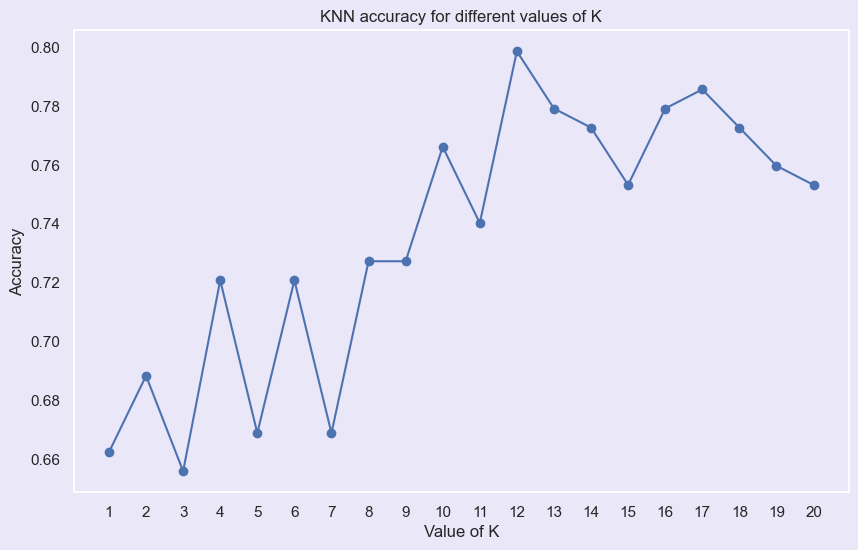

Best value of K: 12
Corresponding accuracy: 0.7987012987012987


In [37]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('KNN accuracy for different values ​​of K')
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(False)
plt.show()

# Find the value of K with the greatest accuracy
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)
print(f"Best value of K: {best_k}")
print(f"Corresponding accuracy: {best_accuracy}")

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=12)

In [39]:
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

acc_train_knn, acc_test_knn, p_knn, r_knn = calculate_metrics(y_train,y_test,y_pred_train,y_pred_test)

acc train: 0.7817589576547231 
acc test: 0.7987012987012987 
precision: 0.7961038961038961 
recall: 0.7987012987012987


### Machine learning models

In [40]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Models to be evaluated
models = [
    # Naive Bayes Model
    GaussianNB(),
    
    # Decision Tree Model
    DecisionTreeClassifier(random_state=42),
    
    # Random forest model
    RandomForestClassifier(n_estimators=100, random_state=42),
    
    # Logistic regression model
    LogisticRegression(random_state=50, max_iter=10000),
    
    # Ada Boost Model
    AdaBoostClassifier(random_state=45),
    
    # XGBoost Model
    # Parameter tree_method='gpu_hist' for XGBoost GPU
    XGBClassifier( random_state=42),
    
    # LightGBM Model
    # Parameter device='gpu' for LightGBM GPU
    LGBMClassifier(num_leaves=31,
                   boosting_type='gbdt',
                   bagging_fraction=0.9,
                   learning_rate=0.05,
                   feature_fraction=0.9,
                   bagging_freq=50,
                   verbose=0,),
    
    # K-Nearest Neighbors Model
    KNeighborsClassifier(n_neighbors=5),
    
    # Support Vector Classifier
    SVC(kernel='linear', probability=True, random_state=42),
    
    # Gradient Boosting Classifier
    GradientBoostingClassifier(random_state=42),
    
    # Neural Network Model
    MLPClassifier(random_state=42, max_iter=1000)
]

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(f"Model {i+1}: {type(model).__name__}")
    acc_train, acc_test, p, r = calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)
    print("-----------------")

Model 1: GaussianNB
acc train: 0.745928338762215 
acc test: 0.7402597402597403 
precision: 0.7509157509157509 
recall: 0.7402597402597403
-----------------
Model 2: DecisionTreeClassifier
acc train: 1.0 
acc test: 0.7337662337662337 
precision: 0.7399949341438703 
recall: 0.7337662337662337
-----------------
Model 3: RandomForestClassifier
acc train: 1.0 
acc test: 0.7207792207792207 
precision: 0.721938775510204 
recall: 0.7207792207792207
-----------------
Model 4: LogisticRegression
acc train: 0.7736156351791531 
acc test: 0.7532467532467533 
precision: 0.7532467532467533 
recall: 0.7532467532467533
-----------------
Model 5: AdaBoostClassifier
acc train: 0.8224755700325733 
acc test: 0.7402597402597403 
precision: 0.7402597402597403 
recall: 0.7402597402597403
-----------------
Model 6: XGBClassifier
acc train: 1.0 
acc test: 0.6883116883116883 
precision: 0.6999825571254144 
recall: 0.6883116883116883
-----------------


Exception in thread Thread-42 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\parha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

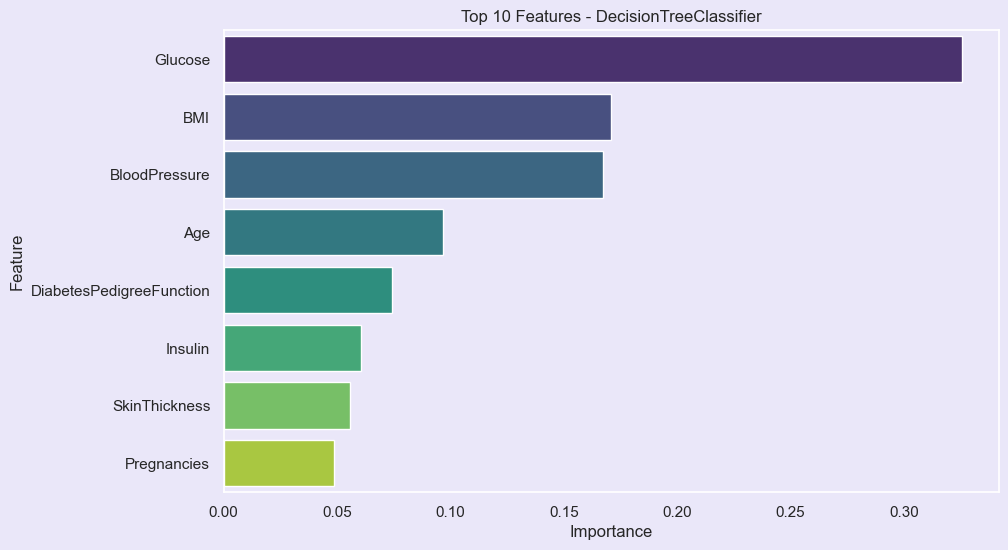

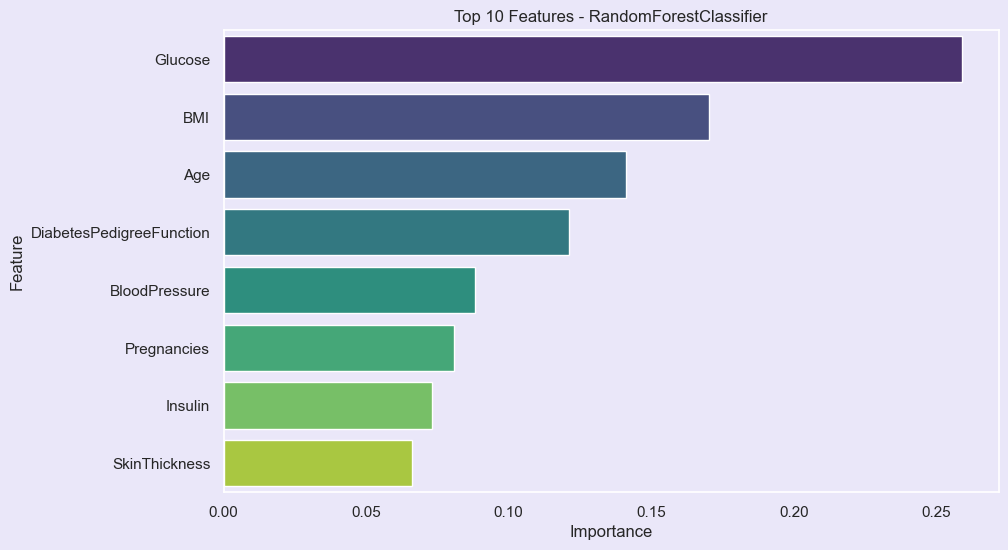

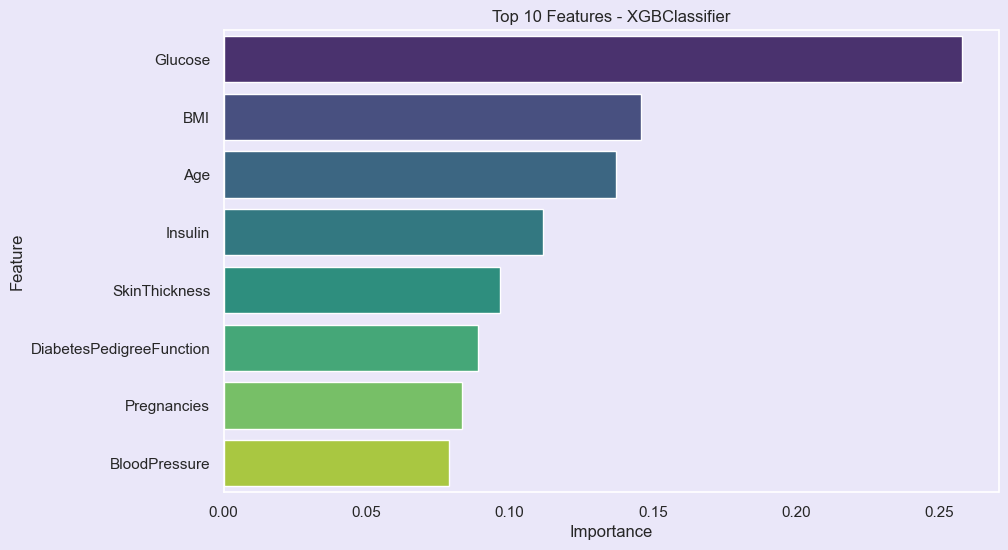

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

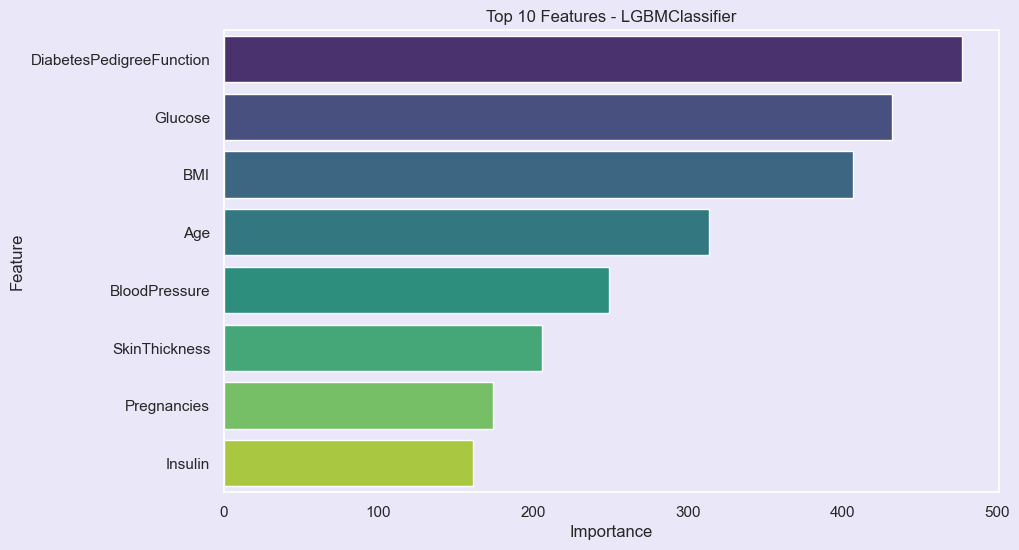

In [41]:
# Train models that support feature importances 
models_with_feature_importances = [("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
                                   ("RandomForestClassifier", RandomForestClassifier(n_estimators=100, random_state=42)),
                                   ("XGBClassifier", XGBClassifier(random_state=42)),
                                   ("LGBMClassifier", LGBMClassifier(random_state=42))]

# Iterate over models
for model_name, model in models_with_feature_importances:
    
    # Train model
    model.fit(X_train, y_train)
    
    # Get importance of features
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        # If the model does not have feature_importances_, continue to the next model
        print(f"{model_name} does not support feature importances.")
        continue

    # Create DataFrame for easier viewing
    feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 
                                           'Importance': feature_importances})
    
    # Sort by importance
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances_df[:10],palette='viridis')
    plt.title(f"Top 10 Features - {model_name}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(False)
    plt.show()

### Part 10- Model Metrics

Model 1: GaussianNB
Training Accuracy: 0.745928338762215
Testing Accuracy: 0.7402597402597403


Confusion matrix 

 [[75 24]
 [16 39]]

True Positives(TP) =  75

True Negatives(TN) =  39

False Positives(FP) =  24

False Negatives(FN) =  16



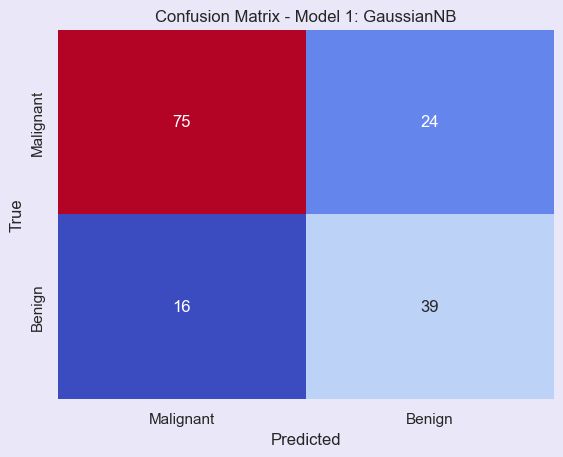

------------------
Model 2: DecisionTreeClassifier
Training Accuracy: 1.0
Testing Accuracy: 0.7337662337662337


Confusion matrix 

 [[76 23]
 [18 37]]

True Positives(TP) =  76

True Negatives(TN) =  37

False Positives(FP) =  23

False Negatives(FN) =  18



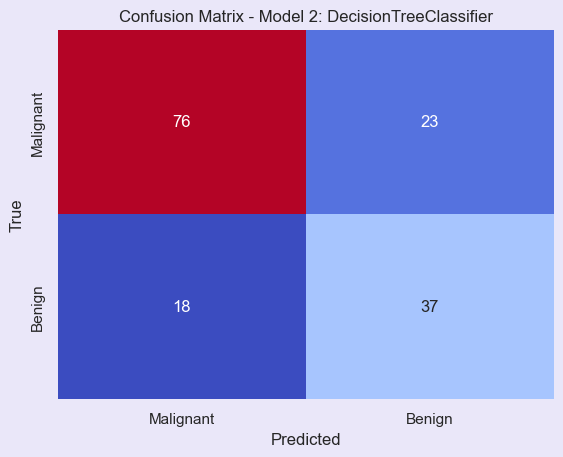

------------------
Model 3: RandomForestClassifier
Training Accuracy: 1.0
Testing Accuracy: 0.7207792207792207


Confusion matrix 

 [[77 22]
 [21 34]]

True Positives(TP) =  77

True Negatives(TN) =  34

False Positives(FP) =  22

False Negatives(FN) =  21



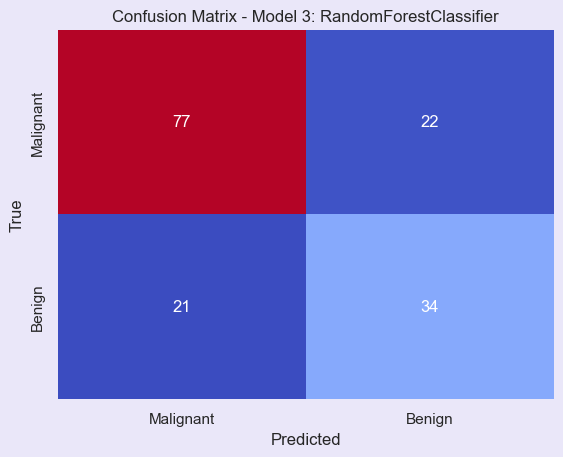

------------------
Model 4: LogisticRegression
Training Accuracy: 0.7736156351791531
Testing Accuracy: 0.7532467532467533


Confusion matrix 

 [[80 19]
 [19 36]]

True Positives(TP) =  80

True Negatives(TN) =  36

False Positives(FP) =  19

False Negatives(FN) =  19



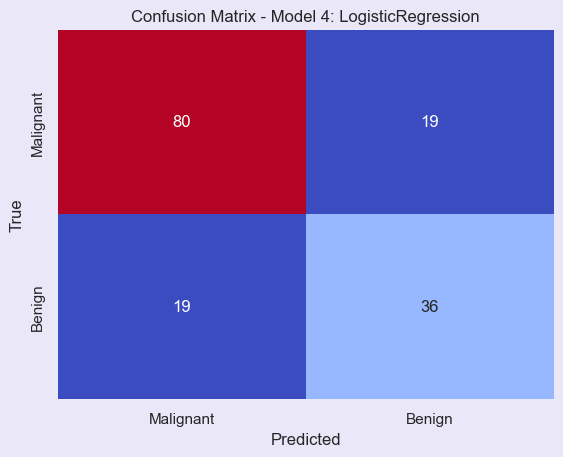

------------------
Model 5: AdaBoostClassifier
Training Accuracy: 0.8224755700325733
Testing Accuracy: 0.7402597402597403


Confusion matrix 

 [[79 20]
 [20 35]]

True Positives(TP) =  79

True Negatives(TN) =  35

False Positives(FP) =  20

False Negatives(FN) =  20



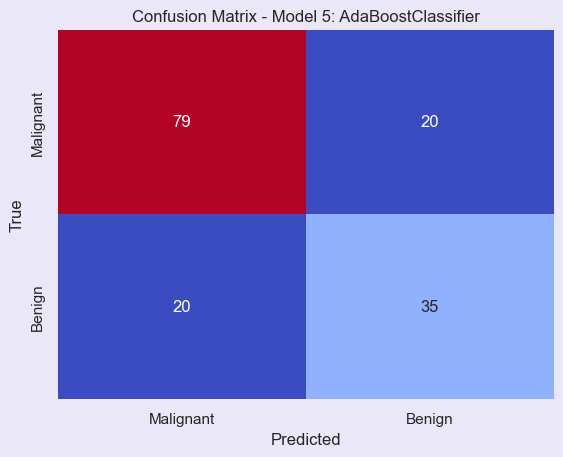

------------------
Model 6: XGBClassifier
Training Accuracy: 1.0
Testing Accuracy: 0.6883116883116883


Confusion matrix 

 [[71 28]
 [20 35]]

True Positives(TP) =  71

True Negatives(TN) =  35

False Positives(FP) =  28

False Negatives(FN) =  20



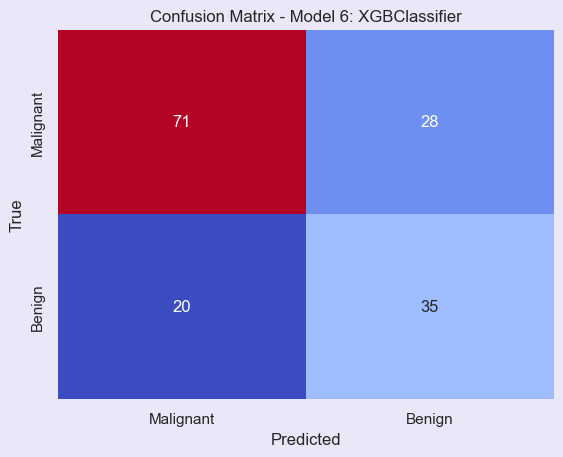

------------------
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=50, subsample_freq=0 will be ignored. Current value: bagging_freq=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

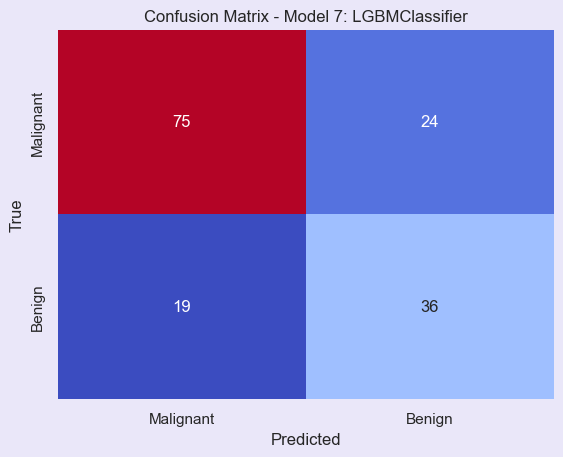

------------------
Model 8: KNeighborsClassifier
Training Accuracy: 0.8061889250814332
Testing Accuracy: 0.6688311688311688


Confusion matrix 

 [[70 29]
 [22 33]]

True Positives(TP) =  70

True Negatives(TN) =  33

False Positives(FP) =  29

False Negatives(FN) =  22



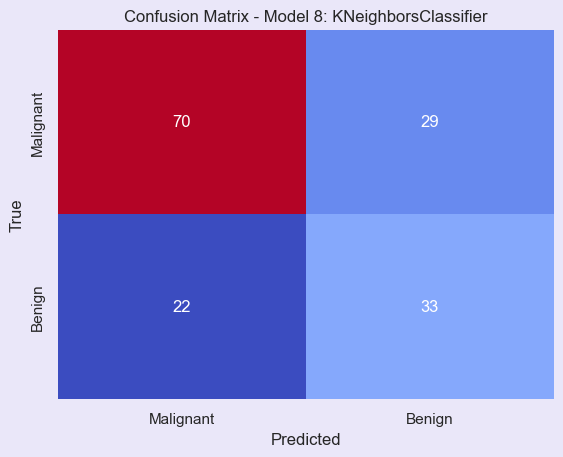

------------------
Model 9: SVC
Training Accuracy: 0.7801302931596091
Testing Accuracy: 0.7662337662337663


Confusion matrix 

 [[82 17]
 [19 36]]

True Positives(TP) =  82

True Negatives(TN) =  36

False Positives(FP) =  17

False Negatives(FN) =  19



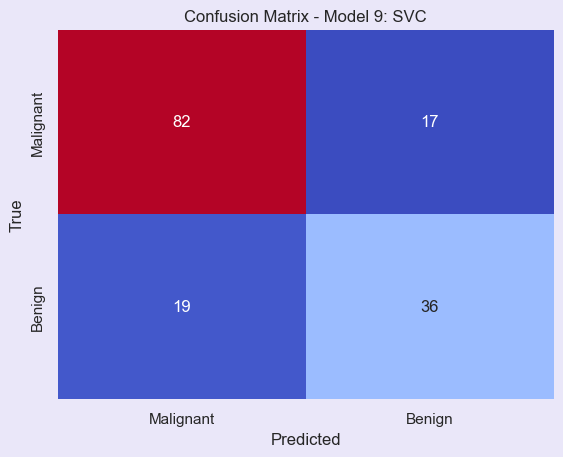

------------------
Model 10: GradientBoostingClassifier
Training Accuracy: 0.9299674267100977
Testing Accuracy: 0.7467532467532467


Confusion matrix 

 [[77 22]
 [17 38]]

True Positives(TP) =  77

True Negatives(TN) =  38

False Positives(FP) =  22

False Negatives(FN) =  17



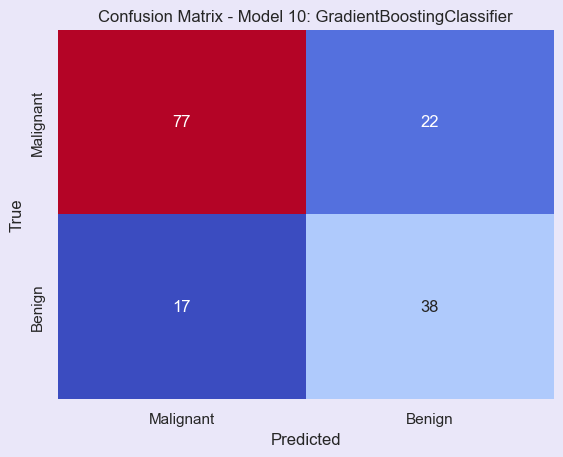

------------------
Model 11: MLPClassifier
Training Accuracy: 0.6384364820846905
Testing Accuracy: 0.5844155844155844


Confusion matrix 

 [[43 56]
 [ 8 47]]

True Positives(TP) =  43

True Negatives(TN) =  47

False Positives(FP) =  56

False Negatives(FN) =  8



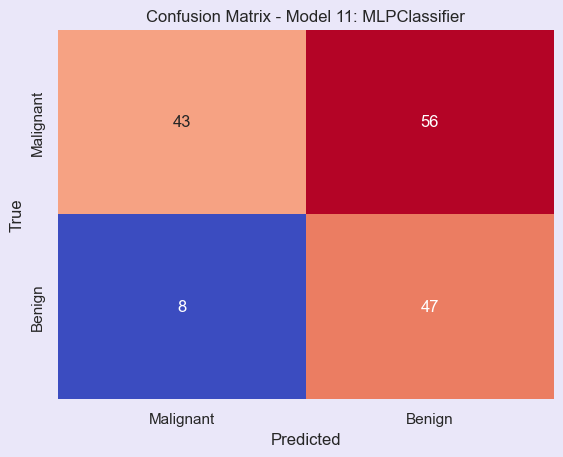

------------------


In [42]:
# plot matrix confusion
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    print(f"Model {i+1}: {type(model).__name__}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print()

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    print()
    print('Confusion matrix \n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    print()
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False, 
                xticklabels=["Malignant", "Benign"], 
                yticklabels=["Malignant", "Benign"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Model {i+1}: {type(model).__name__}")
    plt.show()
    print("------------------")

### Part 10.1 - ROC curve models

Model 1: GaussianNB
Training Accuracy: 0.745928338762215
Testing Accuracy: 0.7402597402597403


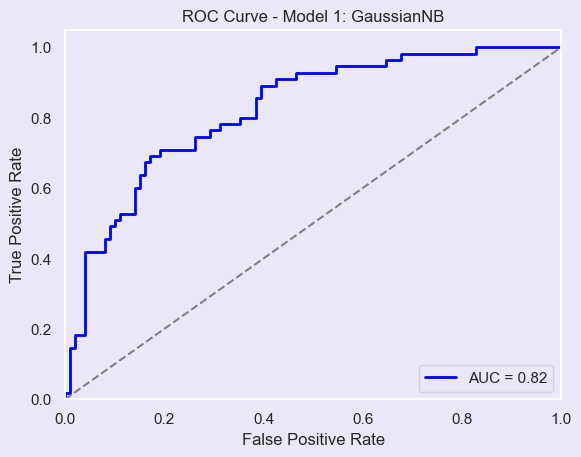

------------------
Model 2: DecisionTreeClassifier
Training Accuracy: 1.0
Testing Accuracy: 0.7337662337662337


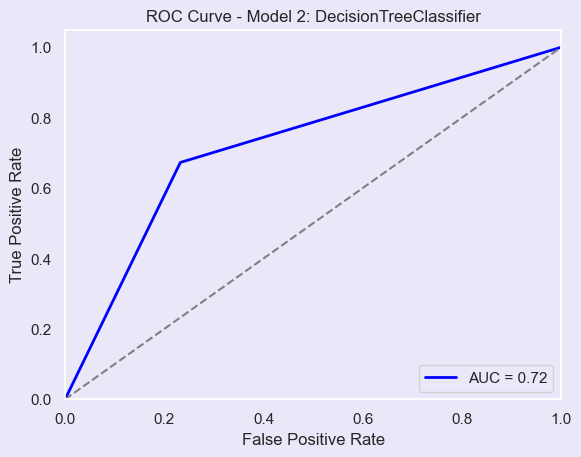

------------------
Model 3: KNeighborsClassifier
Training Accuracy: 0.8061889250814332
Testing Accuracy: 0.6688311688311688


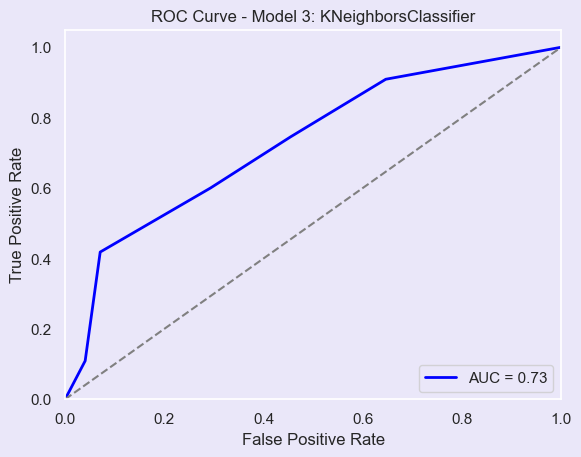

------------------
Model 4: RandomForestClassifier
Training Accuracy: 1.0
Testing Accuracy: 0.7207792207792207


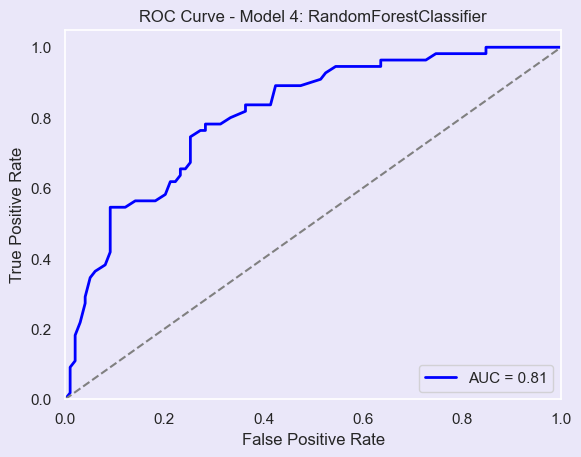

------------------
Model 5: LogisticRegression
Training Accuracy: 0.7687296416938111
Testing Accuracy: 0.7597402597402597


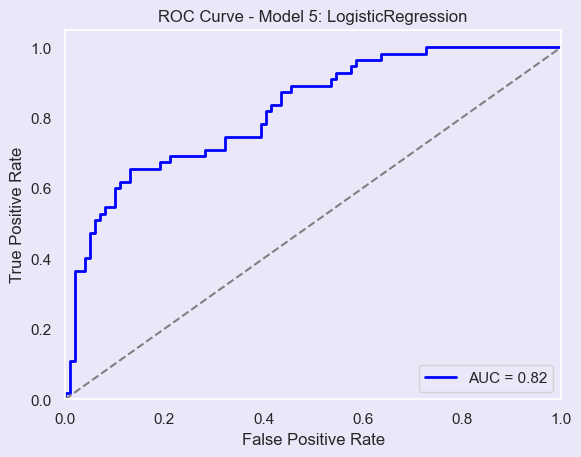

------------------
Model 6: AdaBoostClassifier
Training Accuracy: 0.8224755700325733
Testing Accuracy: 0.7402597402597403


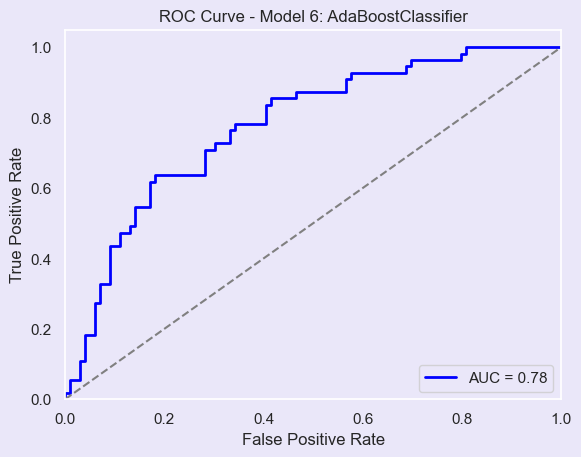

------------------
Model 7: SVC
Training Accuracy: 0.7654723127035831
Testing Accuracy: 0.7662337662337663


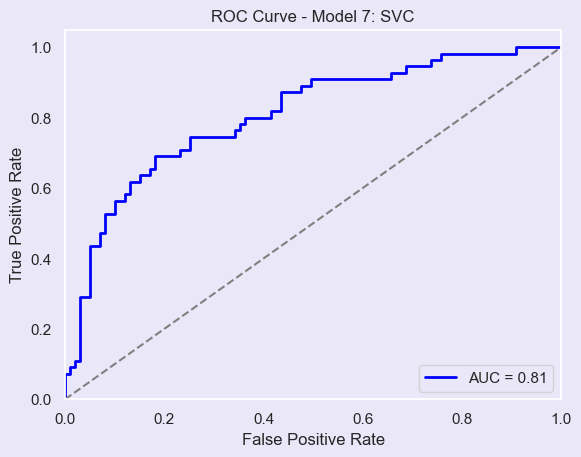

------------------
Model 8: GradientBoostingClassifier
Training Accuracy: 0.9299674267100977
Testing Accuracy: 0.7467532467532467


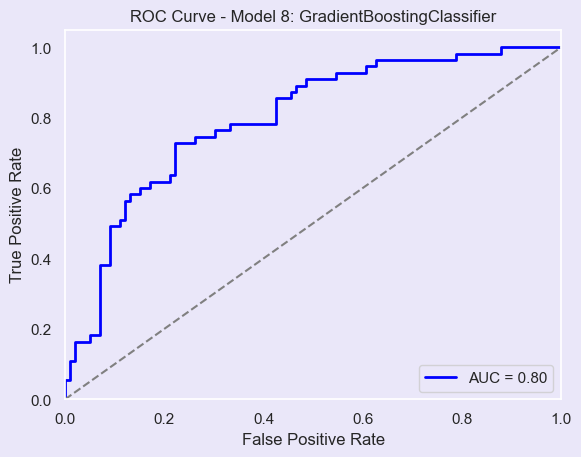

------------------
Model 9: XGBClassifier
Training Accuracy: 1.0
Testing Accuracy: 0.6883116883116883


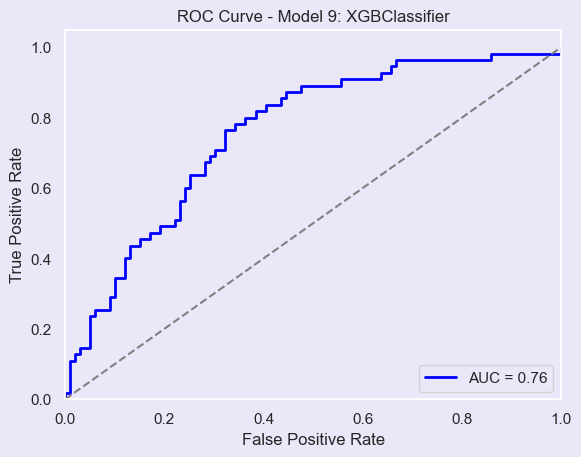

------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

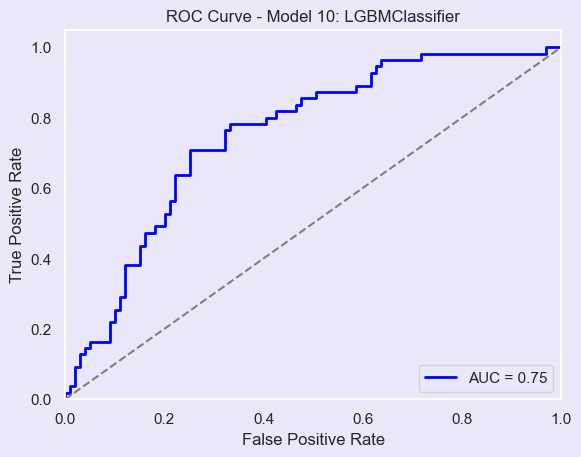

------------------


In [45]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# Models to be evaluated
models = [
    GaussianNB(),
    DecisionTreeClassifier(random_state=42),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    LogisticRegression(random_state=42),
    AdaBoostClassifier(random_state=42),
    SVC(random_state=42, probability=True),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42),
    LGBMClassifier(),
    ]

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"Model {i+1}: {type(model).__name__}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Calculate positive class probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    # Calculate the area under the ROC curve (AUC)
    auc = roc_auc_score(y_test, y_probs)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model {i+1}: {type(model).__name__}')
    plt.legend(loc="lower right")
    plt.grid(False)
    plt.show()
    
    print("------------------")

### Part 10.2 - Classification report

In [44]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Models to be evaluated
models = [
          GaussianNB(),
          DecisionTreeClassifier(random_state=42),
          KNeighborsClassifier(),
          RandomForestClassifier(n_estimators=100, random_state=42),
          LogisticRegression(random_state=42),
          AdaBoostClassifier(random_state=42),
          XGBClassifier(random_state=42),
          LGBMClassifier(),
        ]

# Evaluate each model
for i, model in enumerate(models):
    model.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, model.predict(X_test))
    print()
    
    print(f"Model {i+1}: {type(model).__name__}")
    print()
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate rating report
    report = classification_report(y_test, model.predict(X_test))
    print()
    print("Classification Report:")
    print()
    print(report)
    print()
    
    print("=======================================")


Model 1: GaussianNB

Training Accuracy: 0.745928338762215
Testing Accuracy: 0.7402597402597403

Classification Report:

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79        99
         1.0       0.62      0.71      0.66        55

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.74      0.74       154



Model 2: DecisionTreeClassifier

Training Accuracy: 1.0
Testing Accuracy: 0.7337662337662337

Classification Report:

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79        99
         1.0       0.62      0.67      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154



Model 3: KNeighborsClassifier

Training Accuracy: 0.8061889250814332
Testing Accuracy: 0.66883116883116